## Combating Negative Population Growth in Illinois - Text Analysis on News Articles



### Natural Language Processing & Cognitive Computing

**Author: Targoon Siripanichpong**

Illinois is famous for being one of the very few states in the country with negative population growth.  The objective of your final project is to:

Identify the key reasons for the declining population by extracting meaningful insights from unstructured text
Provide actionable recommendations on what can be done to reverse this trend

The news articles are related to either Chicago and / or Illinois.

To complete your assignment, I suggest considering the following steps:

* Clean-up the noise (eliminate articles irrelevant to the analysis)
* Detect major topics
* Identify top reasons for population decline (negative sentiment)
    - Suggest corrective actions
* Demonstrate how the city / state can attract new businesses (positive sentiment)
* Leverage appropriate NLP techniques to identify organizations and people and apply targeted sentiment
    *  Why businesses should stay in IL or move into IL?
        * Create appropriate visualization to summarize your recommendations (i.e. word cloud chart or bubble chart)
    * Why residents should stay in IL or move into IL?
        * Create appropriate visualization to summarize your recommendations (i.e. word cloud chart or bubble chart)


Additional guidance:

* Default sentiment will likely be wrong from any software package and will require significant tweaking
    - Either keyword / dictionary approach or
    - Labeling and classification
* You are encouraged to explore a combination several techniques to identify key topics:
    - Topic modeling (i.e. LSA, LDA and TF-IDF)
    - Classification (hand-label several topics on a sample and then train classifier)
    - Clustering (cluster topics around pre-selected keywords or word vectors)
* Please limit your work to 7 PowerPoint slides. On your slides you will want to provide:
    - Executive Summary
    - Methodology and source data overview
    - Actionable recommendations
* Please submit your actual program codes (i.e. Python Notebook) along with your PowerPoint – as a separate attachment
* Your presentation should be targeted toward business audience and must not contain any code snippets
* You are welcome to use any software packages of your choice to complete the assignment

### Data Import

In [1]:
import pandas as pd

In [2]:
news_df = pd.read_pickle('../Data/news_chicago_il.pkl')

In [3]:
news_df.head()

crawled language  \
0  2019-04-27T23:25:33.038+03:00  english   
1  2019-04-27T23:27:06.000+03:00  english   
2  2019-04-27T23:28:26.072+03:00  english   
3  2019-04-27T23:29:54.002+03:00  english   
4  2019-04-27T23:30:02.083+03:00  english   

                                                text  \
0  With their second pick in the draft, in Round ...   
1  From an article at the Chicago Tribune by Cont...   
2  Fill in your details below or click an icon to...   
3  Chicago Police Supt. Eddie Johnson (AP Photo/T...   
4  Comment If the Chicago Bulls are willing to ge...   

                                               title  
0  Family affair: Bears fourth-round WR Riley Rid...  
1  Coin Flip Determines Winner Of Election In Chi...  
2  FOX NEWS: Late April storm dumps snow across M...  
3  Chicago Police Department ‘Fixes’ Their FOID R...  
4  Chicago Bulls: 76ers Tobias Harris free agency...

In [4]:
len(news_df)

28604

### Data Preprocessing

In [5]:
import nltk
#nltk.download('popular', halt_on_error=False)
#nltk.download('all', halt_on_error=False)

from nltk.text import Text
import sys
import multiprocessing
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
import inflection as inf
import gensim
import pprint
from gensim import corpora, models
from gensim.models.ldamulticore import LdaMulticore, LdaModel
from gensim.models import CoherenceModel
import pyLDAvis.gensim
import re
from simhash import Simhash, SimhashIndex


In [6]:
news_df['text_original'] = news_df['text'].copy()
news_df['title_original'] = news_df['title'].copy()

#### Text Tokenization

In [7]:
pool = multiprocessing.Pool(processes=7)
news_df['text'] = pool.map(nltk.tokenize.word_tokenize, news_df['text'])
news_df['title'] = pool.map(nltk.tokenize.word_tokenize, news_df['title'])
pool.close()

In [8]:
newStopWords = ['illinois','illinoi', 'chicago', 'united', 'states', 'il', 'us', 'america', 'news', 'live', 'source', 'nbc',
                 'tribune', 'url','http','https','url','ul','img','li','ip','div','noreferrer','af','pa','percent','may',
                    'one','two','three','four','five','six','seven','eight','nine','ten', 'crain', 'hearing', 'press',
                'google', 'facebook', 'twitter', 'tie', 'nyse', 'icon', 'email', 'log'
               ]

In [9]:
def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
def text_preprocessing(words):
    stopwords = nltk.corpus.stopwords.words('english')
    stopwords.extend(newStopWords)
    wnl = WordNetLemmatizer()
    # Remove single-character tokens (mostly punctuation)
    words = [word for word in words if len(word) > 1]
    # Remove numbers
    words = [word for word in words if not word.isnumeric()]
    # Remove punctuation
    words = [word for word in words if word.isalpha()]
    # Lowercase all words (default_stopwords are lowercase too)
    words = [word.lower() for word in words]
    # Remove stopwords
    words = [word for word in words if word not in stopwords]
    # Get PoS Tagging
    words_pos = nltk.pos_tag(words)
    words_pos = [(word, get_wordnet_pos(pos)) for (word, pos) in words_pos]
    # Lemmatize with POS tagging
    words_pos = [(wnl.lemmatize(word, pos), pos) for (word, pos) in words_pos]
    # Singularize words -> (Add police as an exception as the package incorrectly singularizes the word to polouse. 
    # See - https://www.reddit.com/r/memes/comments/8l0lmj/one_polouse_two_police/)
    words = [inf.singularize(word) if (pos == 'n') & (word != 'police') else word for (word, pos) in words_pos]
    return(words)

#### Text Preprocessing

In [10]:
pool = multiprocessing.Pool(processes=7)
news_df['title'] = pool.map(text_preprocessing, news_df['title'])
news_df['text'] = pool.map(text_preprocessing, news_df['text'])
pool.close()

In [11]:
news_df['title'] = [' '.join(token) for token in news_df['title']]
news_df['text'] = [' '.join(token) for token in news_df['text']]

In [12]:
news_df.head()

crawled language  \
0  2019-04-27T23:25:33.038+03:00  english   
1  2019-04-27T23:27:06.000+03:00  english   
2  2019-04-27T23:28:26.072+03:00  english   
3  2019-04-27T23:29:54.002+03:00  english   
4  2019-04-27T23:30:02.083+03:00  english   

                                                text  \
0  second pick draft round overall bear select ge...   
1  article contact reporter ted slowik toss silve...   
2  fill detail click require address never make p...   
3  police supt eddie johnson ap crawford time ent...   
4  comment bull willing get creative free agency ...   

                                               title  \
0    family affair bear wr riley ridley feeling love   
1         coin flip determine winner election suburb   
2  fox late april storm dump snow across midweste...   
3          police department fix foid report problem   
4        bull tobias harris free agency target merit   

                                       text_original  \
0  With their second pick in the draft, in Round ...   
1  From an article at the Chicago Tribune by Cont...   
2  Fill in your details below or click an icon to...   
3  Chicago Police Supt. Eddie Johnson (AP Photo/T...   
4  Comment If the Chicago Bulls are willing to ge...   

                                      title_original  
0  Family affair: Bears fourth-round WR Riley Rid...  
1  Coin Flip Determines Winner Of Election In Chi...  
2  FOX NEWS: Late April storm dumps snow across M...  
3  Chicago Police Department ‘Fixes’ Their FOID R...  
4  Chicago Bulls: 76ers Tobias Harris free agency...

### Data Cleanup & Filtering

#### Duplicate Article Removal

In [13]:
def get_features(s):
    width = 3
    s = s.lower()
    s = re.sub(r'[^\w]+', '', s)
    return [s[i:i + width] for i in range(max(len(s) - width + 1, 1))]

In [14]:
data = news_df['title'].to_dict()
objs = [(str(k), Simhash(get_features(v))) for k, v in data.items()]
index = SimhashIndex(objs, k=3)
news_df['title_near_dups'] = news_df['title'].apply(lambda x: index.get_near_dups(Simhash(get_features(x))))
#near_dup = [list(x) for x in set(tuple(x) for x in news_df['title_near_dups'])]
#nearDup.append([len(x) for x in near_dup if len(x) > 1])
news_df['num_near_dup_titles'] = [len(i) - 1 for i in news_df.title_near_dups]
news_df['IsUnique_title'] = news_df['num_near_dup_titles'].apply(lambda x: True if x == 0 else False)
#UniqueCount.append(news_df.groupby('IsUnique_title').size())

In [15]:
for index, news in news_df.iterrows():
    if (news['IsUnique_title'] == False) and (index != min([int(news_list) for news_list in news['title_near_dups']])):
        news_df.drop(index, inplace=True)

In [16]:
news_df.head()

crawled language  \
0  2019-04-27T23:25:33.038+03:00  english   
1  2019-04-27T23:27:06.000+03:00  english   
2  2019-04-27T23:28:26.072+03:00  english   
3  2019-04-27T23:29:54.002+03:00  english   
4  2019-04-27T23:30:02.083+03:00  english   

                                                text  \
0  second pick draft round overall bear select ge...   
1  article contact reporter ted slowik toss silve...   
2  fill detail click require address never make p...   
3  police supt eddie johnson ap crawford time ent...   
4  comment bull willing get creative free agency ...   

                                               title  \
0    family affair bear wr riley ridley feeling love   
1         coin flip determine winner election suburb   
2  fox late april storm dump snow across midweste...   
3          police department fix foid report problem   
4        bull tobias harris free agency target merit   

                                       text_original  \
0  With their second pick in the draft, in Round ...   
1  From an article at the Chicago Tribune by Cont...   
2  Fill in your details below or click an icon to...   
3  Chicago Police Supt. Eddie Johnson (AP Photo/T...   
4  Comment If the Chicago Bulls are willing to ge...   

                                      title_original title_near_dups  \
0  Family affair: Bears fourth-round WR Riley Rid...     [30, 0, 52]   
1  Coin Flip Determines Winner Of Election In Chi...             [1]   
2  FOX NEWS: Late April storm dumps snow across M...             [2]   
3  Chicago Police Department ‘Fixes’ Their FOID R...             [3]   
4  Chicago Bulls: 76ers Tobias Harris free agency...             [4]   

   num_near_dup_titles  IsUnique_title  
0                    2           False  
1                    0            True  
2                    0            True  
3                    0            True  
4                    0            True

In [17]:
news_df.shape

(19870, 9)

#### Topic Modeling (LDA)

In [18]:
pool = multiprocessing.Pool(processes=7)
news_df['title'] = pool.map(nltk.tokenize.word_tokenize, news_df['title'])
pool.close()

dictionary = corpora.Dictionary(news_df['title'])
dictionary.filter_extremes(no_below=5, no_above=0.1)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in news_df['title']]

coherence_score = []
lda_model_list = []
lda_model = LdaMulticore(doc_term_matrix, num_topics=30, id2word = dictionary, passes=100, random_state=43)
print(*lda_model.print_topics(num_words=6), sep='\n')
lda_model_list.append(lda_model)
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=news_df['title'], dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
coherence_score.append(coherence_lda)
print('\nCoherence Score: ', coherence_lda)
print('=========================================')

(16, '0.067*"time" + 0.030*"book" + 0.030*"part" + 0.019*"trump" + 0.016*"driver" + 0.014*"owner"')
(26, '0.064*"service" + 0.044*"company" + 0.043*"move" + 0.038*"credit" + 0.033*"consumer" + 0.025*"bank"')
(19, '0.078*"park" + 0.067*"home" + 0.058*"sale" + 0.019*"april" + 0.019*"room" + 0.018*"year"')
(0, '0.064*"police" + 0.041*"man" + 0.031*"officer" + 0.025*"week" + 0.022*"crash" + 0.021*"girl"')
(27, '0.026*"get" + 0.023*"go" + 0.021*"water" + 0.018*"make" + 0.016*"take" + 0.015*"look"')
(8, '0.044*"big" + 0.043*"open" + 0.030*"event" + 0.028*"flight" + 0.023*"trip" + 0.023*"round"')
(4, '0.164*"new" + 0.031*"york" + 0.024*"hotel" + 0.019*"early" + 0.019*"alert" + 0.019*"video"')
(17, '0.050*"summer" + 0.025*"northern" + 0.023*"next" + 0.019*"office" + 0.016*"future" + 0.016*"need"')
(25, '0.061*"shot" + 0.034*"announce" + 0.032*"district" + 0.027*"fire" + 0.026*"plan" + 0.025*"galena"')
(29, '0.104*"work" + 0.084*"tool" + 0.072*"itw" + 0.046*"share" + 0.029*"llc" + 0.028*"inc"')

In [19]:
lda_display = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary, sort_topics=False, mds='mmds')
pyLDAvis.display(lda_display)

/home/targoon/.local/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [20]:
from operator import itemgetter
news_df['topic'] = [max(lda_model[title], key=itemgetter(1))[0] + 1 for title in doc_term_matrix]

#### Topic Removal

In [21]:
#Drop topics
# Topic 30 - This topic largely consists of news about a company called Illinois Tool Works and not necessarily related to the state of Illinois
# Topic 24 - This topic largely consists of job postings in Illinois
# Topic 29 - This topic is related to memorial day weekend
# Topic 14 - This topic is related to an unfortunate event happened to a pregnant woman
topics_to_drop = [30, 29, 24, 14]

In [22]:
news_df_filtered = news_df[~news_df['topic'].isin(topics_to_drop)]

In [23]:
news_df_filtered.shape

(16636, 10)

#### High/Low Word Count Removal

In [24]:
#Discard article with title less than four words and more than 50 words
news_df_filtered = news_df_filtered[news_df_filtered['title'].map(len) > 3]
news_df_filtered = news_df_filtered[news_df_filtered['text_original'].map(len) > 3]
news_df_filtered = news_df_filtered[news_df_filtered['title'].map(len) < 50]

In [25]:
news_df_filtered.shape

(13302, 10)

#### Keyword-based Topic Identification & Removal

In [26]:
news_df_filtered['title'] = [' '.join(token) for token in news_df_filtered['title']]

In [27]:
#Topic to discard
#Discard articles about sports news
dc_list_sports = ('cub', 'sox', 'bull', 'bear', 'ncaa', 'nba', 'nfl', 'blackhawk', 'fight illini', 'mlb', 'football', 'hockey',
                 'baseball', 'basketball', 'soccer', 'nhl', 'chicago fire', 'series', 'final', 'softball', 'fire', 'track', 'championship',
                  'jose earthquake', 'england revolution', ' vs ', 'ohio state'
                 )
dc_list_sports = '|'.join(dc_list_sports)

#Discard articles about weather news given that there is not a lot the state can do to influence the weather
dc_list_weather = ('snow', 'storm', 'weather')
dc_list_weather = '|'.join(dc_list_weather)

#Discard articles about TV shows, movies, and actors/actress
dc_list_tv = ('finale', 'episode', 'film', 'kardashian', 'foxx', 'jussie', 'smollett''jussie', 'smollett', 'theater', 'star war')
dc_list_tv = '|'.join(dc_list_tv)

#Discard articles about job postings, ads, flight/hotel promotions, and companies with Chicago/Illinois in their names
dc_list_job_ads = ('sale', 'recruit', 'tool work', 'built chicago', 'trip', 'flight', 'airfare', 'lodge', 'move company', 'shipping', 'counsel', 
                  'credit', 'https', 'granite', 'hotel', 'inc oi', 'ship company')
dc_list_job_ads = '|'.join(dc_list_job_ads)

#Discard news about one-time occurrence news & festivals
dc_list_other = ('womb', 'baby', 'explosion', 'plant', 'pregnant', 'star wars', 'memorial', 'festival')
dc_list_other = '|'.join(dc_list_other)

In [28]:
news_df_filtered = news_df_filtered[~news_df_filtered['title'].str.contains(dc_list_sports, regex=True)]
news_df_filtered = news_df_filtered[~news_df_filtered['title'].str.contains(dc_list_weather, regex=True)]
news_df_filtered = news_df_filtered[~news_df_filtered['title'].str.contains(dc_list_tv, regex=True)]
news_df_filtered = news_df_filtered[~news_df_filtered['title'].str.contains(dc_list_job_ads, regex=True)]
news_df_filtered = news_df_filtered[~news_df_filtered['title'].str.contains(dc_list_other, regex=True)]

In [29]:
news_df_filtered.shape

(9371, 10)

In [30]:
news_df_filtered.reset_index(inplace=True)

In [31]:
news_df_filtered.to_pickle('news_df_filtered.pkl')

### Topic Modeling (Again)

#### Number of Topic Selection

**Test different number of topics and select the most appropriate number of topics**

In [114]:
dictionary = corpora.Dictionary(news_df_filtered['title'])
dictionary.filter_extremes(no_below=5, no_above=0.1)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in news_df_filtered['title']]

coherence_score = []
lda_model_list = []
for i in range(20,45,5):
    lda_model = LdaMulticore(doc_term_matrix, num_topics=i, id2word = dictionary, passes=100, random_state=42)
    print(*lda_model.print_topics(num_words=6), sep='\n')
    lda_model_list.append(lda_model)
    # Compute Coherence Score
    coherence_model_lda = CoherenceModel(model=lda_model, texts=news_df_filtered['title'], dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_score.append(coherence_lda)
    print('\nCoherence Score: ', coherence_lda)
    print('=========================================')

(0, '0.072*"police" + 0.030*"man" + 0.024*"officer" + 0.023*"report" + 0.021*"side" + 0.021*"shot"')
(1, '0.048*"plan" + 0.032*"marijuana" + 0.025*"lawmaker" + 0.025*"bill" + 0.024*"announce" + 0.023*"legalize"')
(2, '0.078*"school" + 0.052*"high" + 0.042*"student" + 0.020*"white" + 0.018*"area" + 0.013*"teacher"')
(3, '0.036*"park" + 0.031*"center" + 0.029*"lake" + 0.020*"head" + 0.018*"michigan" + 0.018*"event"')
(4, '0.028*"award" + 0.026*"company" + 0.026*"national" + 0.022*"water" + 0.021*"association" + 0.019*"dog"')
(5, '0.134*"new" + 0.023*"time" + 0.019*"york" + 0.018*"come" + 0.018*"food" + 0.018*"restaurant"')
(6, '0.019*"real" + 0.019*"estate" + 0.017*"conference" + 0.017*"name" + 0.016*"southern" + 0.014*"state"')
(7, '0.064*"state" + 0.063*"tax" + 0.023*"senate" + 0.016*"house" + 0.016*"want" + 0.015*"move"')
(8, '0.030*"county" + 0.029*"electric" + 0.022*"part" + 0.021*"propose" + 0.021*"vehicle" + 0.021*"fee"')
(9, '0.030*"house" + 0.022*"driver" + 0.021*"patch" + 0.020


Coherence Score:  0.5041701707881531
(13, '0.122*"get" + 0.058*"need" + 0.036*"like" + 0.028*"know" + 0.027*"grow" + 0.026*"look"')
(15, '0.087*"go" + 0.050*"med" + 0.030*"leave" + 0.023*"let" + 0.023*"legal" + 0.021*"pd"')
(23, '0.056*"best" + 0.049*"crusader" + 0.043*"art" + 0.042*"world" + 0.038*"host" + 0.033*"spring"')
(33, '0.072*"water" + 0.057*"american" + 0.037*"show" + 0.037*"offer" + 0.032*"right" + 0.016*"pro"')
(27, '0.053*"april" + 0.049*"southern" + 0.045*"bring" + 0.044*"job" + 0.030*"usa" + 0.022*"love"')
(26, '0.055*"business" + 0.042*"real" + 0.040*"estate" + 0.038*"police" + 0.034*"attack" + 0.027*"attempt"')
(39, '0.060*"law" + 0.060*"central" + 0.049*"event" + 0.043*"east" + 0.036*"book" + 0.031*"indiana"')
(4, '0.067*"company" + 0.037*"dog" + 0.036*"height" + 0.035*"river" + 0.034*"feature" + 0.027*"hot"')
(24, '0.071*"sport" + 0.040*"blue" + 0.039*"bank" + 0.038*"bet" + 0.023*"start" + 0.021*"jordan"')
(35, '0.101*"park" + 0.044*"food" + 0.041*"use" + 0.038*"re

#### Coherence Score Plot

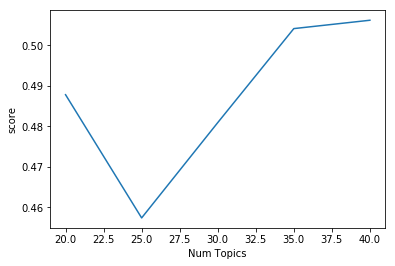

In [115]:
import matplotlib.pyplot as plt
x = range(20,45,5)
plt.plot(x, coherence_score)
plt.xlabel("Num Topics")
plt.ylabel("score")
plt.show()

Based on the plot and visual topic inspection, k=20 should be an appropriate number of topics.

In [117]:
lda_display = pyLDAvis.gensim.prepare(lda_model_list[0], doc_term_matrix, dictionary, sort_topics=False, mds='mmds')
pyLDAvis.display(lda_display)

/home/targoon/.local/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


### Sentiment Analysis

#### Overall Sentiment Analysis

**Creating a list of keywords of interest to create a subset of data for analysis**

In [32]:
kw_list = ('population', 'demographic', ' residents', ' resident ', 'citizen', 'homeowner', 'community', 'neighborhood',
          'living', 'suburb', 'downtown', 'statehouse', 'communities', 'city', 'firm', 'company', 'companies', 'organization', 'startup', 'corporation', 'business', 'corporate', 'headquarter',
                   'office ', 'offices', 'tax')
kw_list = '|'.join(kw_list)

In [33]:
news_df_filtered_kw = news_df_filtered[news_df_filtered['title'].str.contains(kw_list, regex=True)]

In [34]:
news_df_filtered_kw.shape

(1020, 11)

**Apply Default Vader Sentiment Analyzer to the subset of filtered articles**

In [35]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()
results = []
for index, news in news_df_filtered_kw.iterrows():
    pol_score = sia.polarity_scores(news.title)
    results.append(pol_score['compound'])
news_df_filtered_kw['pol_score'] = results
news_df_filtered_kw.sort_values(['pol_score'], inplace=True)

/home/targoon/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/home/targoon/.local/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


**Inspect the titles and sentiment scores. Create dictionaries of words that should be added/removed from the default sentiment analyzer.**

In [36]:
for index, news in news_df_filtered_kw.iterrows():
    print(news['title'])
    print(str(news['pol_score'])+ '\n')

person kill other injured separate shooting university village neighborhood early sunday morning person kill other injure around shoot block south throop street age sex shoot readily available acenewsdesk report
-0.9628

french widow file lawsuit aircraft manufacturer boeing million damage crash ethiopian airline max march kill person board include husband frenchwoman nadege whose husband jonathan seex die accident file suit boeing company headquarter
-0.9612

company allow physical abuse shut abuser punish sent jail animal cruelty
-0.9349

police look person sexually assault deaf woman rob city southwest side thursday police say attack happen west street specific detail attack release
-0.9274

man sentence year plead guilty downtown terrorism bomb plot
-0.8834

man shoot death thursday englewood home south side living room residence block south laflin street someone shot room side window say
-0.8481

suburban man give year prison terrorism plot blow crowd downtown bar
-0.836

come tog

alderman new city council
0.0

lawmaker push drug company list price
0.0

could raise ev registration fee hike ga tax watt
0.0

springfield residential relocating company
0.0

choose tub refinish company
0.0

farmer merna biography george mecherle history state farm insurance company bloomington book
0.0

city lasalle valley regional dispatch board committee meet april
0.0

ward central railroad company
0.0

pritzker graduate tax amendment could pass house thursday
0.0

aside graduated tax proposal dems consider least fee tax hike
0.0

river meet marina city
0.0

video capture street buckle downtown
0.0

senate set vote graduate income tax plan
0.0

suburban democrat replace house committee advance tax rate bill daily herald politic informer
0.0

business wire adm mill recall
0.0

governor propose tax video gambling
0.0

suburban teacher prep program model effort teach pipeline
0.0

progressive income tax rate pass house committee wo call full vote friday
0.0

dance life annual perform


iam mechanic local member community
0.0

guideline follow find corporate real estate attorney
0.0

mom send business deal boyfriend set
0.0

business analyst sdg csdg
0.0

review sa business class stockholm
0.0

house progressive caucu pan senate bid end estate tax
0.0

modern farmhouse suburb vium wordpress
0.0

yseali pfp day garfield conservatory city landscape
0.0

far away yunnan china recent living room rearrangement still say
0.0

state police trooper dress construction worker nab speeder near quad city
0.0

pepsico partner national restaurant association educational foundation invest community collaborative train youth reentry population restaurant career marketscreener
0.0

lgbtq guide windy city heat spring summer
0.0

city dixon national public work week nw
0.0

wintrust business lunch brothel economic business mayor lightfoot emanuel next job
0.0

acre waterfront subdivision land suburban
0.0

could hike cigarette tax
0.0

various artist downtown blue
0.0

discount concaca


tip find excellent corporate real estate attorney
0.5719

american forest paper association highlight value paper wood product industry state annualbusiness day
0.5859

coin flip determine winner election suburb
0.5859

family office exchange fox invite linda mack present integrate wealth advisor council meeting april
0.5859

highlight value paper wood product industry state annualbusiness day
0.5859

nearly million visitor help set new tourism record city say tourism create job throughout city emanuel say statement continue set new tourism record bring million person every year generate economic
0.5859

sbdc announce student business pitch winner
0.5859

discount hamilton ticket new york appleton atlantum austin baltimore east lansing fort myer fort worth grand rapid houston indianapolis kansas city louisville promo
0.5994

brigadier general stephen curda discuss join force organization design help veteran
0.5994

beautiful sterling silver ring meet west suburb
0.5994

darin lahood l

In [37]:
#Positive words & negative words to add
pos_words_add_key = ('launch', 'thrive', 'perk', 'perks', 'reform', 'reforms', 'elite', 'hope', 'hopes', 'celebration', 'sustainable', 'complete',
                    'completion', 'grow', 'grows', 'grew', 'grown', 'heal', 'upgrade')

neg_words_add_key = ('decline', 'declining', 'declined', 'declines', 
                     'refrain', 'refrains', 'refrained', 'refraining',
                     'shelve', 'shelved', 'shelves', 
                     'exacerbate', 'exacerbates', 'exacerbated',
                     'worsen', 'fewer', 'charge', 'charged', 'charges', 'closure', 'closures'
                 'challenge', 'challenges', 'dysfunctional', 'slip', 'sue', 'supremacist', 'burden', 'slips', 'sues', 'sued',
                    'fall', 'falls','demonstration', 'lawsuits', 'lawsuit', 'oppose','opposition', 'hike', 'toll', 'burdensome'
                    'critique', 'bogus', 'restriction', 'defeat')

#Words to remove
word_to_remove = ('serious', 'surprise', 'solution','like', 'top', 'advantage', 'importance', 'engaging', 
                  'moody', 'award', 'winner', 'free', 'love', 'lovely', 'engagement', 'trust', 'great', 'best', 'destroy', 'war',
                 'sunny', 'guarantee', 'ok', 'increase', 'fair', 'clear', 'worth', 'heaven', 'richest' , 'rofl')

**Update the lexicon**

In [38]:
sia = SentimentIntensityAnalyzer()
new_pos_words = dict(zip(pos_words_add_key, [1] * len(pos_words_add_key)))
new_neg_words = dict(zip(neg_words_add_key, [-1] * len(neg_words_add_key)))

sia.lexicon.update(new_pos_words)
sia.lexicon.update(new_neg_words)

for word in word_to_remove:
    sia.lexicon.pop(word)

**Apply the updated lexicon to all filtered articles**

In [39]:
results = []
for index, news in news_df_filtered.iterrows():
    pol_score = sia.polarity_scores(news.title)['compound']
    results.append(pol_score)
news_df_filtered['pol_score'] = results
news_df_filtered.sort_values(['pol_score'], inplace=True)

In [40]:
news_df_filtered_neg = news_df_filtered[news_df_filtered['pol_score'] < -0.01]
news_df_filtered_pos = news_df_filtered[news_df_filtered['pol_score'] > 0.01]

In [41]:
news_df_filtered_neg.shape, news_df_filtered_pos.shape

((2260, 12), (2236, 12))

**Validate the bigram frequencies**

In [143]:
pool = multiprocessing.Pool(processes=7)
news_df_filtered_neg['text'] = pool.map(nltk.tokenize.word_tokenize, news_df_filtered_neg['text'])
news_df_filtered_neg['title'] = pool.map(nltk.tokenize.word_tokenize, news_df_filtered_neg['title'])
pool.close()

#Flatten the list
flatten_word_list_neg = []
for words in news_df_filtered_neg['text']:
    flatten_word_list_neg += words
flatten_word_list_neg = list(filter(None, flatten_word_list_neg)) 

bigrams_neg = nltk.bigrams([w for w in flatten_word_list_neg])

fdist = nltk.FreqDist(bigrams_neg)
fdist.most_common(200)

[(('police', 'officer'), 35),
 (('high', 'school'), 32),
 (('plead', 'guilty'), 31),
 (('police', 'say'), 23),
 (('lori', 'lightfoot'), 23),
 (('electric', 'vehicle'), 23),
 (('sentence', 'year'), 20),
 (('man', 'charge'), 19),
 (('man', 'sentence'), 17),
 (('state', 'police'), 17),
 (('shot', 'kill'), 16),
 (('guilty', 'murder'), 15),
 (('year', 'prison'), 15),
 (('boy', 'find'), 15),
 (('man', 'kill'), 14),
 (('south', 'side'), 14),
 (('fatally', 'shot'), 13),
 (('man', 'accuse'), 13),
 (('lightfoot', 'swear'), 13),
 (('sexually', 'assault'), 12),
 (('parent', 'boy'), 12),
 (('grave', 'plead'), 12),
 (('block', 'club'), 12),
 (('registration', 'fee'), 12),
 (('find', 'grave'), 11),
 (('red', 'line'), 11),
 (('school', 'student'), 11),
 (('red', 'star'), 11),
 (('police', 'warn'), 11),
 (('tax', 'hike'), 11),
 (('mayor', 'lori'), 10),
 (('west', 'side'), 10),
 (('former', 'police'), 10),
 (('person', 'shot'), 10),
 (('police', 'scene'), 10),
 (('officer', 'injure'), 10),
 (('man', 'ar

In [145]:
pool = multiprocessing.Pool(processes=7)
news_df_filtered_pos['text'] = pool.map(nltk.tokenize.word_tokenize, news_df_filtered_pos['text'])
news_df_filtered_pos['title'] = pool.map(nltk.tokenize.word_tokenize, news_df_filtered_pos['title'])
pool.close()

#Flatten the list
flatten_word_list_pos = []
for words in news_df_filtered_pos['text']:
    flatten_word_list_pos += words
flatten_word_list_pos = list(filter(None, flatten_word_list_pos)) 

bigrams_pos = nltk.bigrams([w for w in flatten_word_list_pos])

fdist = nltk.FreqDist(bigrams_pos)
fdist.most_common(200)

[(('high', 'school'), 19),
 (('supreme', 'court'), 19),
 (('american', 'water'), 17),
 (('lori', 'lightfoot'), 17),
 (('new', 'york'), 16),
 (('rahm', 'emanuel'), 13),
 (('bill', 'would'), 12),
 (('early', 'clue'), 11),
 (('clue', 'case'), 11),
 (('mayor', 'rahm'), 11),
 (('cook', 'county'), 10),
 (('health', 'care'), 10),
 (('alert', 'early'), 10),
 (('sweet', 'home'), 10),
 (('red', 'star'), 9),
 (('kiss', 'fm'), 9),
 (('real', 'estate'), 9),
 (('clean', 'energy'), 9),
 (('new', 'mayor'), 8),
 (('usa', 'job'), 8),
 (('black', 'woman'), 8),
 (('symphony', 'orchestra'), 8),
 (('police', 'reform'), 8),
 (('first', 'bancshares'), 8),
 (('legalize', 'marijuana'), 8),
 (('bank', 'marathon'), 8),
 (('food', 'truck'), 8),
 (('mother', 'day'), 8),
 (('mississippi', 'river'), 7),
 (('sport', 'bet'), 7),
 (('school', 'spend'), 7),
 (('mandatory', 'water'), 7),
 (('pls', 'rt'), 7),
 (('catholic', 'church'), 7),
 (('big', 'reform'), 7),
 (('swear', 'mayor'), 7),
 (('application', 'grow'), 7),
 ((

**Create an additional stopword list to filter out meaningless bigrams**

In [129]:
stopwords = ['year', 'york', 'comment', 'use', 'account', 'say', 'last', 'make', 'take', 'even', 'high',
            'would', 'could', 'should', 'have', 'has', 'star', 'share', 'across', 'foot', 'person', 'city', 'softball',
            'job', 'every', 'like', 'american', 'want', 'get', 'first','also', 'sox', 'court', 'truck', 'martial']
is_stopwords = lambda x: x not in stopwords

In [148]:
flatten_word_list_neg_cleaned = list(filter(is_stopwords, flatten_word_list_neg))
flatten_word_list_pos_cleaned = list(filter(is_stopwords, flatten_word_list_pos))

**Create wordclouds**

In [93]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
from PIL import Image
from numpy import random

In [94]:
def red_color_func(word=None, font_size=None, position=None, orientation=None, font_path=None, random_state=None):
        return "hsl(10, 100%%, %d%%)" % random.randint(40, 70)

def green_color_func(word=None, font_size=None, position=None, orientation=None, font_path=None, random_state=None):
    return "hsl(120, 88%%, %d%%)" % random.randint(20, 50)
    
def create_bigram_word_cloud(word_list, sentiment, outfilename):
    finder = BigramCollocationFinder.from_words(word_list)
    bigram_measures = BigramAssocMeasures()
    scored = finder.score_ngrams(bigram_measures.raw_freq)

    scoredList = sorted(scored, key=itemgetter(1), reverse=True)
    word_dict = {}

    listLen = len(scoredList)

    # Get the bigram and make a contiguous string for the dictionary key. 
    # Set the key to the scored value. 
    for i in range(listLen):
        word_dict[' '.join(scoredList[i][0])] = scoredList[i][1]


    # Generate a word cloud image
    WC_width = 2000
    WC_height = 1000
    WC_max_words = 200
    if sentiment == 'neg':
        wordCloud = WordCloud(max_words=WC_max_words, height=WC_height, width=WC_width, 
                              background_color="white", color_func=red_color_func)
    else:
        wordCloud = WordCloud(max_words=WC_max_words, height=WC_height, width=WC_width, 
                              background_color="white", color_func=green_color_func)
        
    wordCloud.generate_from_frequencies(word_dict)
    wordCloud.to_file(outfilename)
    plt.figure( figsize=(20,10), facecolor='w')
    plt.imshow(wordCloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

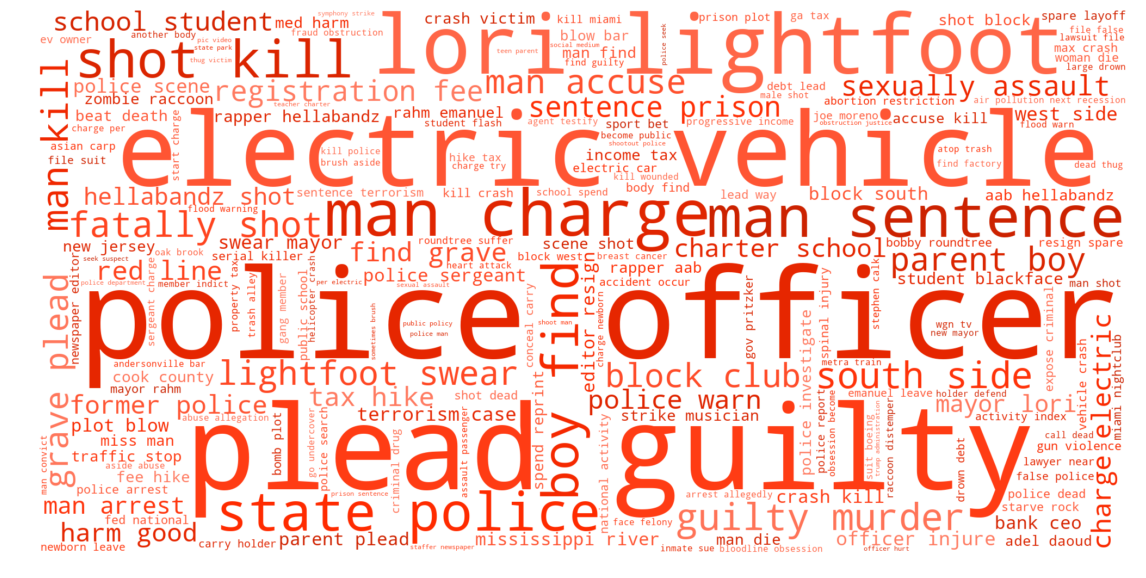

In [149]:
create_bigram_word_cloud(flatten_word_list_neg_cleaned, 'neg', 'generic_sentiment_neg.png')

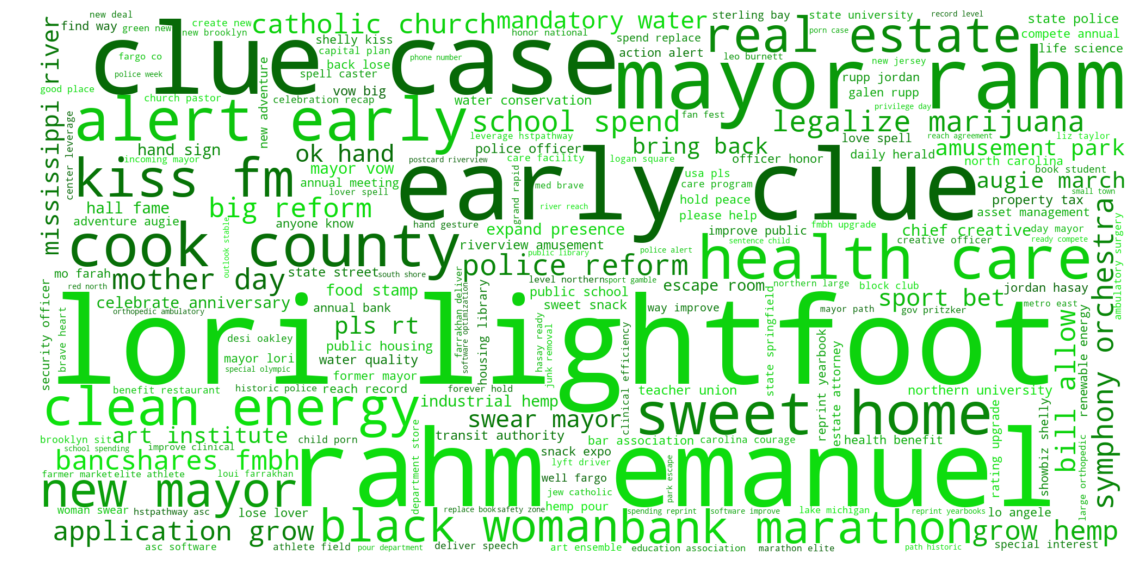

In [150]:
create_bigram_word_cloud(flatten_word_list_pos_cleaned, 'pos', 'generic_sentiment_pos.png')

In [48]:
news_df_filtered_pos.reset_index(inplace=True, drop=True)
news_df_filtered_neg.reset_index(inplace=True, drop=True)

In [49]:
news_df_filtered_pos.to_pickle('news_df_filtered_pos.pkl')
news_df_filtered_neg.to_pickle('news_df_filtered_neg.pkl')

#### Named Entity Recognition

**Leverage Stanford NLP NER Tagger for Entity Recognition**

In [51]:
from nltk.tag import StanfordNERTagger
import os

path = '/home/targoon/Desktop/Natural Language Processing/Assignment/StanfordCoreNLP/stanford-ner-2018-10-16/'

# initialize NER tagger
sn = StanfordNERTagger(path + 'classifiers/english.all.3class.distsim.crf.ser.gz',
                       path_to_jar=path + 'stanford-ner-3.9.2.jar')

/home/targoon/.local/lib/python3.7/site-packages/nltk/tag/stanford.py:201: DeprecationWarning: 
The StanfordTokenizer will be deprecated in version 3.2.6.
Please use nltk.parse.corenlp.CoreNLPParser instead.
  super(StanfordNERTagger, self).__init__(*args, **kwargs)


In [54]:
def NER_extraction(title):
    named_entities = []
    enr_tag = sn.tag(title.split())
    temp_entity_name = ''
    temp_named_entity = None
    for term, tag in enr_tag:
        if tag != 'O':
            temp_entity_name = ' '.join([temp_entity_name, term]).strip()
            temp_named_entity = (temp_entity_name, tag)
        else:
            if temp_named_entity:
                named_entities.append(temp_named_entity)
                temp_entity_name = ''
                temp_named_entity = None
    return named_entities

In [55]:
pool = multiprocessing.Pool(processes=7)
news_df_filtered_pos['entity'] = pool.map(NER_extraction, news_df_filtered_pos['title_original'])
pool.close()

/home/targoon/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [56]:
pool = multiprocessing.Pool(processes=7)
news_df_filtered_neg['entity'] = pool.map(NER_extraction, news_df_filtered_neg['title_original'])
pool.close()

/home/targoon/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [57]:
news_df_filtered_pos.to_pickle('news_df_filtered_pos.pkl')
news_df_filtered_neg.to_pickle('news_df_filtered_neg.pkl')

In [72]:
def get_org(entities):
    return [itemgetter(0)(entity) for entity in entities if itemgetter(1)(entity) == 'ORGANIZATION']

def get_person(entities):
    return [itemgetter(0)(entity) for entity in entities if itemgetter(1)(entity) == 'PERSON']

In [73]:
news_df_filtered_pos['entity_org'] = news_df_filtered_pos['entity'].apply(get_org)
news_df_filtered_pos['entity_person'] = news_df_filtered_pos['entity'].apply(get_person)

/home/targoon/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/targoon/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [74]:
news_df_filtered_neg['entity_org'] = news_df_filtered_neg['entity'].apply(get_org)
news_df_filtered_neg['entity_person'] = news_df_filtered_neg['entity'].apply(get_person)

/home/targoon/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/targoon/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [118]:
news_df_filtered_neg.head()

index                        crawled language  \
0  26643  2019-05-25T06:59:19.001+03:00  english   
1  27891  2019-05-26T20:47:45.003+03:00  english   
2  23976  2019-05-22T21:09:07.021+03:00  english   
3  21746  2019-05-20T16:28:23.013+03:00  english   
4  14124  2019-05-11T19:53:16.009+03:00  english   

                                                text  \
0  [friday, senseless, killing, north, charleston...   
1  [ace, worldwide, group, person, kill, other, i...   
2  [learn, english, reading, least, sentence, per...   
3  [sissy, deric, need, expose, slut, know, find,...   
4  [aj, freund, parent, plead, guilty, murder, so...   

                                               title  \
0  [senseless, killing, north, charleston, black,...   
1  [person, kill, other, injured, separate, shoot...   
2  [french, widow, file, lawsuit, aircraft, manuf...   
3  [sissy, deric, need, expose, slut, know, find,...   
4  [aj, freund, parent, plead, guilty, murder, so...   

                                       text_original  \
0   Friday, May 24, 2019 Senseless Killings in No...   
1  Ace Worldwide News Group 18:11 on 26/05/2019 (...   
2  LEARN ENGLISH BY READING AT LEAST 1 SENTENCE P...   
3  Sissy Deric in Chicago needs to be exposed as ...   
4   AJ Freund's parents plead not guilty to murde...   

                                      title_original        title_near_dups  \
0  Senseless Killings in North Charleston. Black ...         [26643, 26647]   
1  (CHICAGO, Illinois.) JUST IN: Three people wer...                [27891]   
2  A French widow has filed a lawsuit against US ...                [23976]   
3  Sissy Deric in Chicago needs to be exposed as ...                [21746]   
4  AJ Freund's parents plead not guilty to murder...  [14124, 14402, 14590]   

   num_near_dup_titles  IsUnique_title  topic  pol_score  \
0                    1           False     19    -0.9652   
1                    0            True     10    -0.9628   
2                    0            True      5    -0.9618   
3                    0            True     28    -0.9607   
4                    2           False     20    -0.9460   

                                              entity  \
0  [(North Charleston. Black on Black Crimes., OR...   
1                   [(University Village, LOCATION)]   
2  [(US, LOCATION), (Boeing, ORGANIZATION), (Jona...   
3       [(Sissy Deric, PERSON), (Chicago, LOCATION)]   
4                                                 []   

                                   entity_org    entity_person  
0  [North Charleston. Black on Black Crimes.]               []  
1                                          []               []  
2                            [Boeing, Boeing]  [Jonathan Seex]  
3                                          []    [Sissy Deric]  
4                                          []               []

**Filter for only articles with existing entities**

In [81]:
def len_0(x):
    if len(x) > 0:
        return True
    else:
        return False

In [85]:
news_df_filtered_pos_targeted_org = news_df_filtered_pos[list(map(len_0, news_df_filtered_pos.entity_org))]
news_df_filtered_pos_targeted_person = news_df_filtered_pos[list(map(len_0, news_df_filtered_pos.entity_person))]

news_df_filtered_neg_targeted_org = news_df_filtered_neg[list(map(len_0, news_df_filtered_neg.entity_org))]
news_df_filtered_neg_targeted_person = news_df_filtered_neg[list(map(len_0, news_df_filtered_neg.entity_person))]

In [151]:
news_df_filtered_pos_targeted_org.head()

index                        crawled language  \
3   16424  2019-05-15T00:28:28.006+03:00  english   
4   26213  2019-05-24T21:04:47.017+03:00  english   
12   9829  2019-05-07T11:09:38.007+03:00  english   
16    182  2019-04-28T02:25:12.024+03:00  english   
23  19636  2019-05-18T02:29:15.011+03:00  english   

                                                 text  \
3   [nra, board, member, say, new, president, lie,...   
4   [relatively, low, forward, ratio, detect, shar...   
12  [low, current, ratio, construction, engineerin...   
16  [share, link, crime, terrorism, migration, rea...   
23  [pritzker, capital, plan, would, double, ga, t...   

                                                title  \
3            [ordered, pay, nra, million, legal, fee]   
4   [relatively, low, forward, ratio, detect, shar...   
12  [low, current, ratio, construction, engineerin...   
16  [presidential, election, investigation, facts,...   
23  [pritzker, capital, plan, would, double, ga, t...   

                                        text_original  \
3   NRA Board Members Say New President Lied About...   
4   Relatively Low Forward P/E Ratio Detected in S...   
12  Lowest Current Ratio in the Construction & Eng...   
16  1 Share The link between Crime, Terrorism, and...   
23  facebook Pritzker capital plan would double Il...   

                                       title_original title_near_dups  \
3   Chicago Ordered to Pay NRA $1 Million for Lega...         [16424]   
4   Relatively Low Forward P/E Ratio Detected in S...         [26213]   
12  Lowest Current Ratio in the Construction & Eng...          [9829]   
16  “2016 Presidential Election Investigation” – G...           [182]   
23  Pritzker capital plan would double Illinois ga...         [19636]   

    num_near_dup_titles  IsUnique_title  topic  pol_score  \
3                     0            True     11     0.0258   
4                     0            True      4     0.0258   
12                    0            True     13     0.0258   
16                    0            True      3     0.0258   
23                    0            True     23     0.0258   

                                               entity  \
3          [(Chicago, LOCATION), (NRA, ORGANIZATION)]   
4   [(Owens-Illinois, ORGANIZATION), (Metal & Glas...   
12  [(Construction & Engineering Industry Detected...   
16  [(Google, ORGANIZATION), (Facebook, ORGANIZATI...   
23  [(Pritzker, PERSON), (Illinois, LOCATION), (Ne...   

                                           entity_org entity_person  
3                                               [NRA]            []  
4   [Owens-Illinois, Metal & Glass Containers Indu...            []  
12  [Construction & Engineering Industry Detected ...            []  
16                                 [Google, Facebook]            []  
23                                          [Netflix]    [Pritzker]

In [86]:
print(news_df_filtered_pos_targeted_org.shape, news_df_filtered_pos_targeted_person.shape)

(586, 15) (314, 15)


In [87]:
print(news_df_filtered_neg_targeted_org.shape, news_df_filtered_neg_targeted_person.shape)

(435, 15) (326, 15)


**Create Wordclouds**

In [130]:
flatten_word_list_neg_targeted_org = []
for words in news_df_filtered_neg_targeted_org['text']:
    flatten_word_list_neg_targeted_org += words
flatten_word_list_neg_targeted_org = list(filter(None, flatten_word_list_neg_targeted_org)) 
flatten_word_list_neg_targeted_org_cleaned = list(filter(is_stopwords, flatten_word_list_neg_targeted_org))

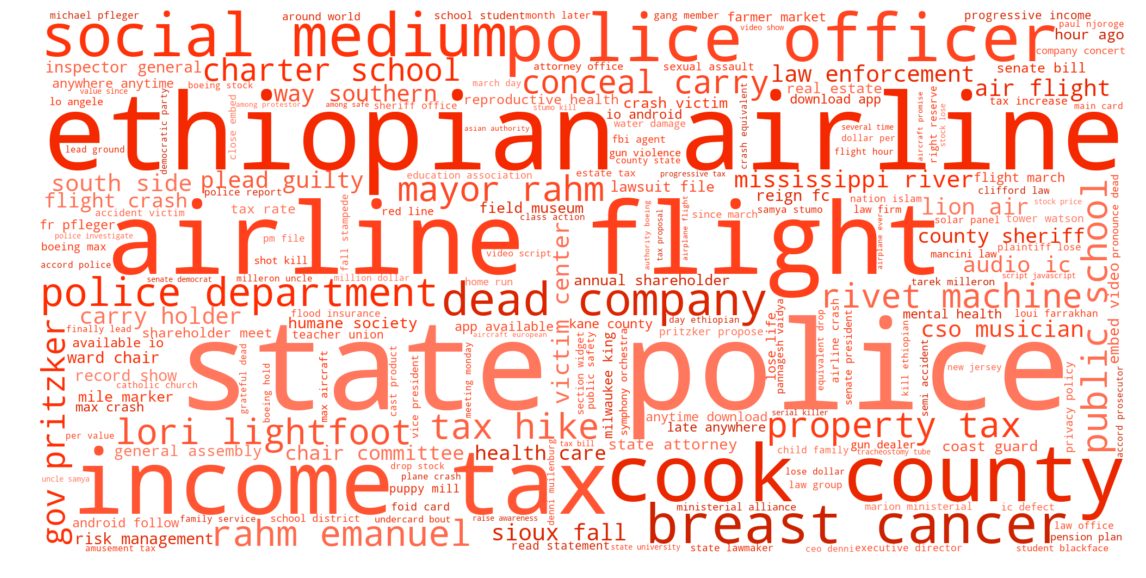

In [131]:
create_bigram_word_cloud(flatten_word_list_neg_targeted_org_cleaned, 'neg', 'org_sentiment_neg.png')

In [132]:
flatten_word_list_neg_targeted_person = []
for words in news_df_filtered_neg_targeted_person['text']:
    flatten_word_list_neg_targeted_person += words
flatten_word_list_neg_targeted_person = list(filter(None, flatten_word_list_neg_targeted_person)) 
flatten_word_list_neg_targeted_person_cleaned = list(filter(is_stopwords, flatten_word_list_neg_targeted_person))

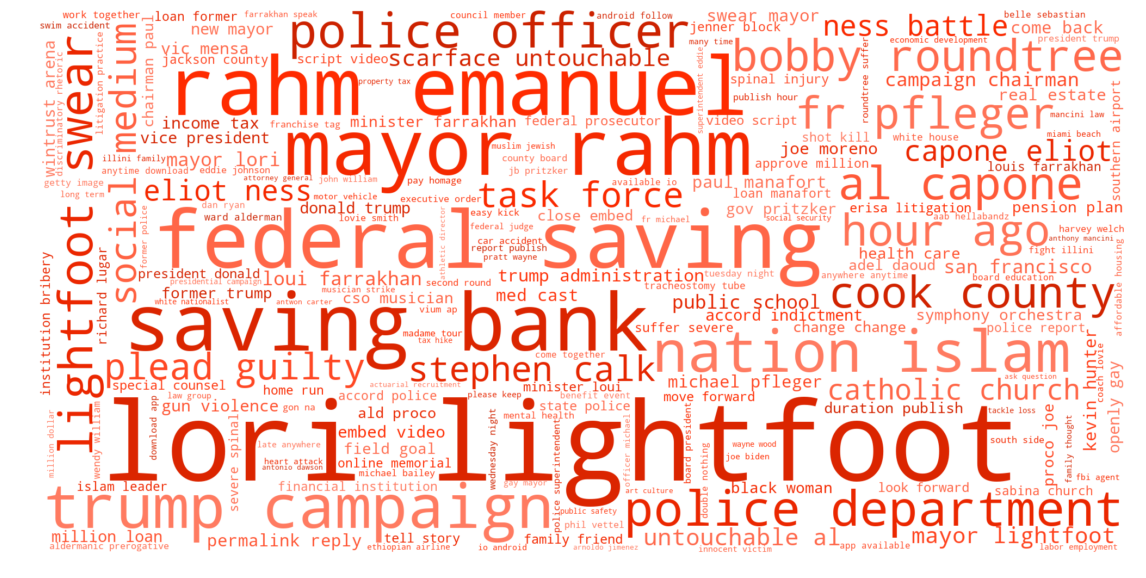

In [133]:
create_bigram_word_cloud(flatten_word_list_neg_targeted_person_cleaned, 'neg', 'person_sentiment_pos.png')

In [134]:
flatten_word_list_pos_targeted_org = []
for words in news_df_filtered_pos_targeted_org['text']:
    flatten_word_list_pos_targeted_org += words
flatten_word_list_pos_targeted_org = list(filter(None, flatten_word_list_pos_targeted_org)) 
flatten_word_list_pos_targeted_org_cleaned = list(filter(is_stopwords, flatten_word_list_pos_targeted_org))

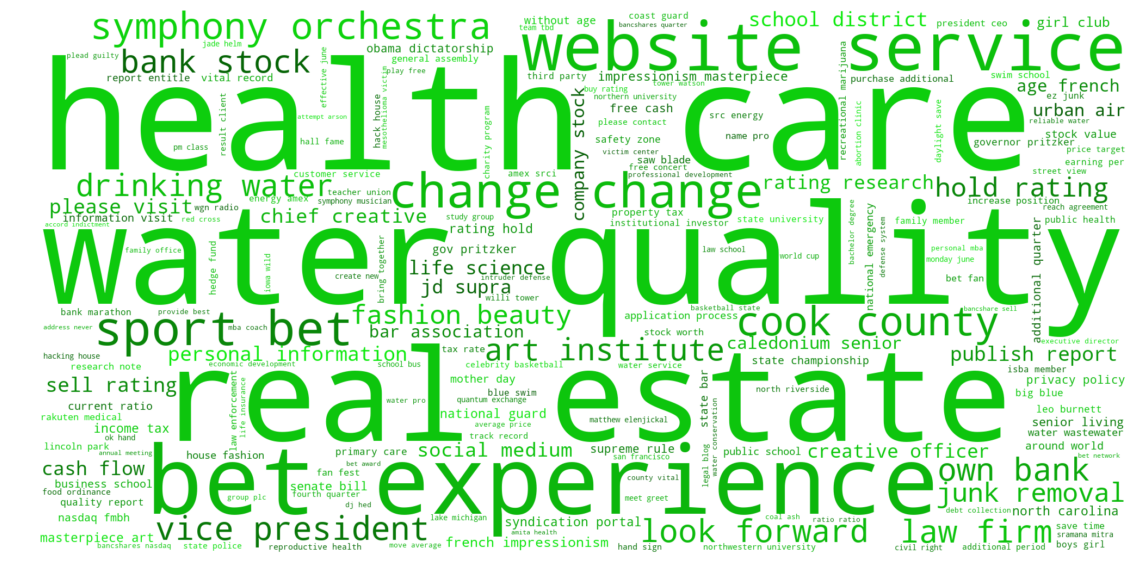

In [135]:
create_bigram_word_cloud(flatten_word_list_pos_targeted_org_cleaned, 'pos', 'org_sentiment_pos.png')

In [136]:
flatten_word_list_pos_targeted_person = []
for words in news_df_filtered_pos_targeted_person['text']:
    flatten_word_list_pos_targeted_person += words
flatten_word_list_pos_targeted_person = list(filter(None, flatten_word_list_pos_targeted_person)) 
flatten_word_list_pos_targeted_person_cleaned = list(filter(is_stopwords, flatten_word_list_pos_targeted_person))

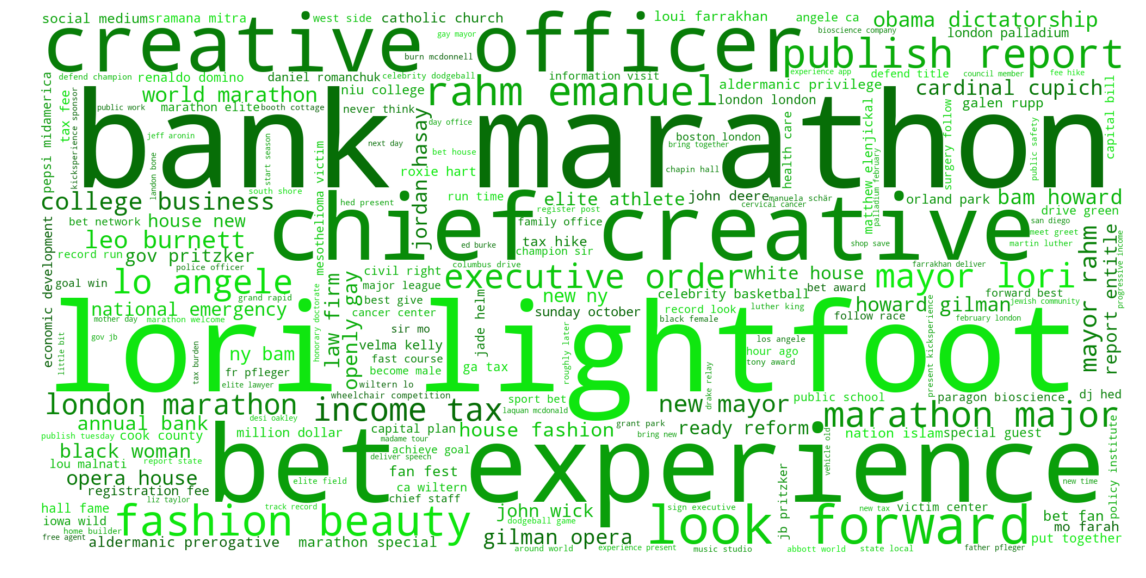

In [137]:
create_bigram_word_cloud(flatten_word_list_pos_targeted_person_cleaned, 'pos', 'person_sentiment_pos.png')